# 05-clustering-&-association-rule-mining

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


___ 
## 1. Business Understanding

___ 
## 2. Data Understanding

#### 2.1 This dataset contains the locations of customers. The dataset has the following columns:

- clientid - The unique identifier for the customer
- x - The x coordinate of the customer's location, when plotted into a 2D plane
- y - The y coordinate of the customer's location, when plotted into a 2D plane

In [24]:
drone_cust_locations = pd.read_csv('../datasets/drone_cust_locations.csv', sep=';')

drone_cust_locations.head()

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


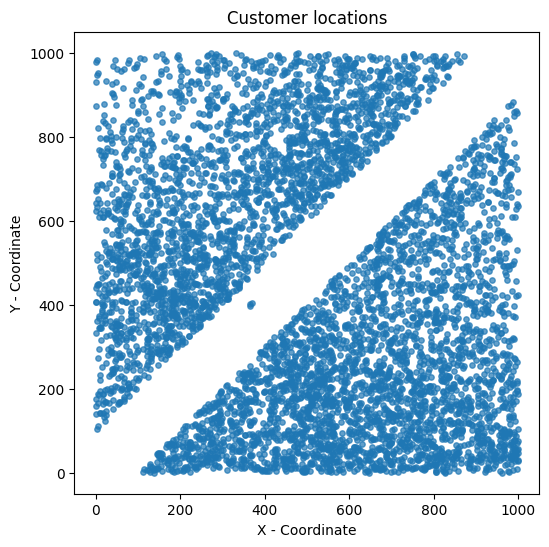

In [30]:
plt.figure(figsize=(6, 6))
plt.scatter(drone_cust_locations["x"], drone_cust_locations["y"], s=15, alpha=0.7)
plt.xlabel("X - Coordinate")
plt.ylabel("Y - Coordinate")
plt.title("Customer locations")
plt.show()

#### 2.2 This dataset contains the sales data for products. The dataset has the following columns:

- ID - The transaction ID
- Prod1, ..., Prod20 - Binary variables indicating whether at least one product from a particular group was purchased in the transaction. A value of 1 indicates that at least one product from the group was purchased, while a value of 0 indicates that no products from the group were purchased.

In [31]:
drone_prod_groups = pd.read_csv('../datasets/drone_prod_groups.csv')
drone_prod_groups.head()

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


___ 
## 3. Data Preparation

___ 
## 4. Modeling

___ 
## 5. Evaluation

___ 
## 6. Deployment